In [1]:
import numpy as np
import json
import re
import tensorflow as tf
import random
import spacy
import seaborn as sns
from sklearn.model_selection import train_test_split

nlp = spacy.load('en_core_web_sm')

with open('/content/merged.json') as f:
    intents = json.load(f)

def preprocessing(line):
    line = re.sub(r'[^a-zA-z.?!\']', ' ', line)
    line = re.sub(r'[ ]+', ' ', line)
    return line

classes = []
inputs = []
targets = []
intent_doc = {}

for intent_name, intent_data in intents.items():
    if intent_name not in classes:
        classes.append(intent_name)
    if intent_name not in intent_doc:
        intent_doc[intent_name] = []

    if 'utterances' in intent_data:
        for utterance in intent_data['utterances']:
            inputs.append(preprocessing(utterance))
            targets.append(intent_name)
            
        for response in intent_data['responses']:
            intent_doc[intent_name].append(response)

def tokenize_data(input_list):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<unk>')
    
    tokenizer.fit_on_texts(input_list)
    
    input_seq = tokenizer.texts_to_sequences(input_list)

    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, padding='pre')
    
    return tokenizer, input_seq

# preprocess input data
tokenizer, input_tensor = tokenize_data(inputs)

def create_categorical_target(targets):
    word={}
    categorical_target=[]
    counter=0
    for trg in targets:
        if trg not in word:
            word[trg]=counter
            counter+=1
        categorical_target.append(word[trg])
    
    categorical_tensor = tf.keras.utils.to_categorical(categorical_target, num_classes=len(word), dtype='int32')
    return categorical_tensor, dict((v,k) for k, v in word.items())

# preprocess output data
target_tensor, trg_index_word = create_categorical_target(targets)

print('input shape: {} and output shape: {}'.format(input_tensor.shape, target_tensor.shape))

# split the data into training and testing sets
train_input, test_input, train_target, test_target = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)

# hyperparameters
epochs=100
vocab_size=len(tokenizer.word_index) + 1
embed_dim=300
units=128
target_length=target_tensor.shape[1]

# load pre-trained word embeddings
embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_dim)
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim, input_length=input_tensor.shape[1], trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, dropout=0.3, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, dropout=0.3)),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_length, activation='softmax')
])


optimizer = tf.keras.optimizers.Adam(lr=1e-2)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

from sklearn.model_selection import train_test_split

#training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stop])


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


input shape: (1473, 13) and output shape: (1473, 84)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 13, 300)           171900    
                                                                 
 bidirectional (Bidirectiona  (None, 13, 256)          439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 84)                5

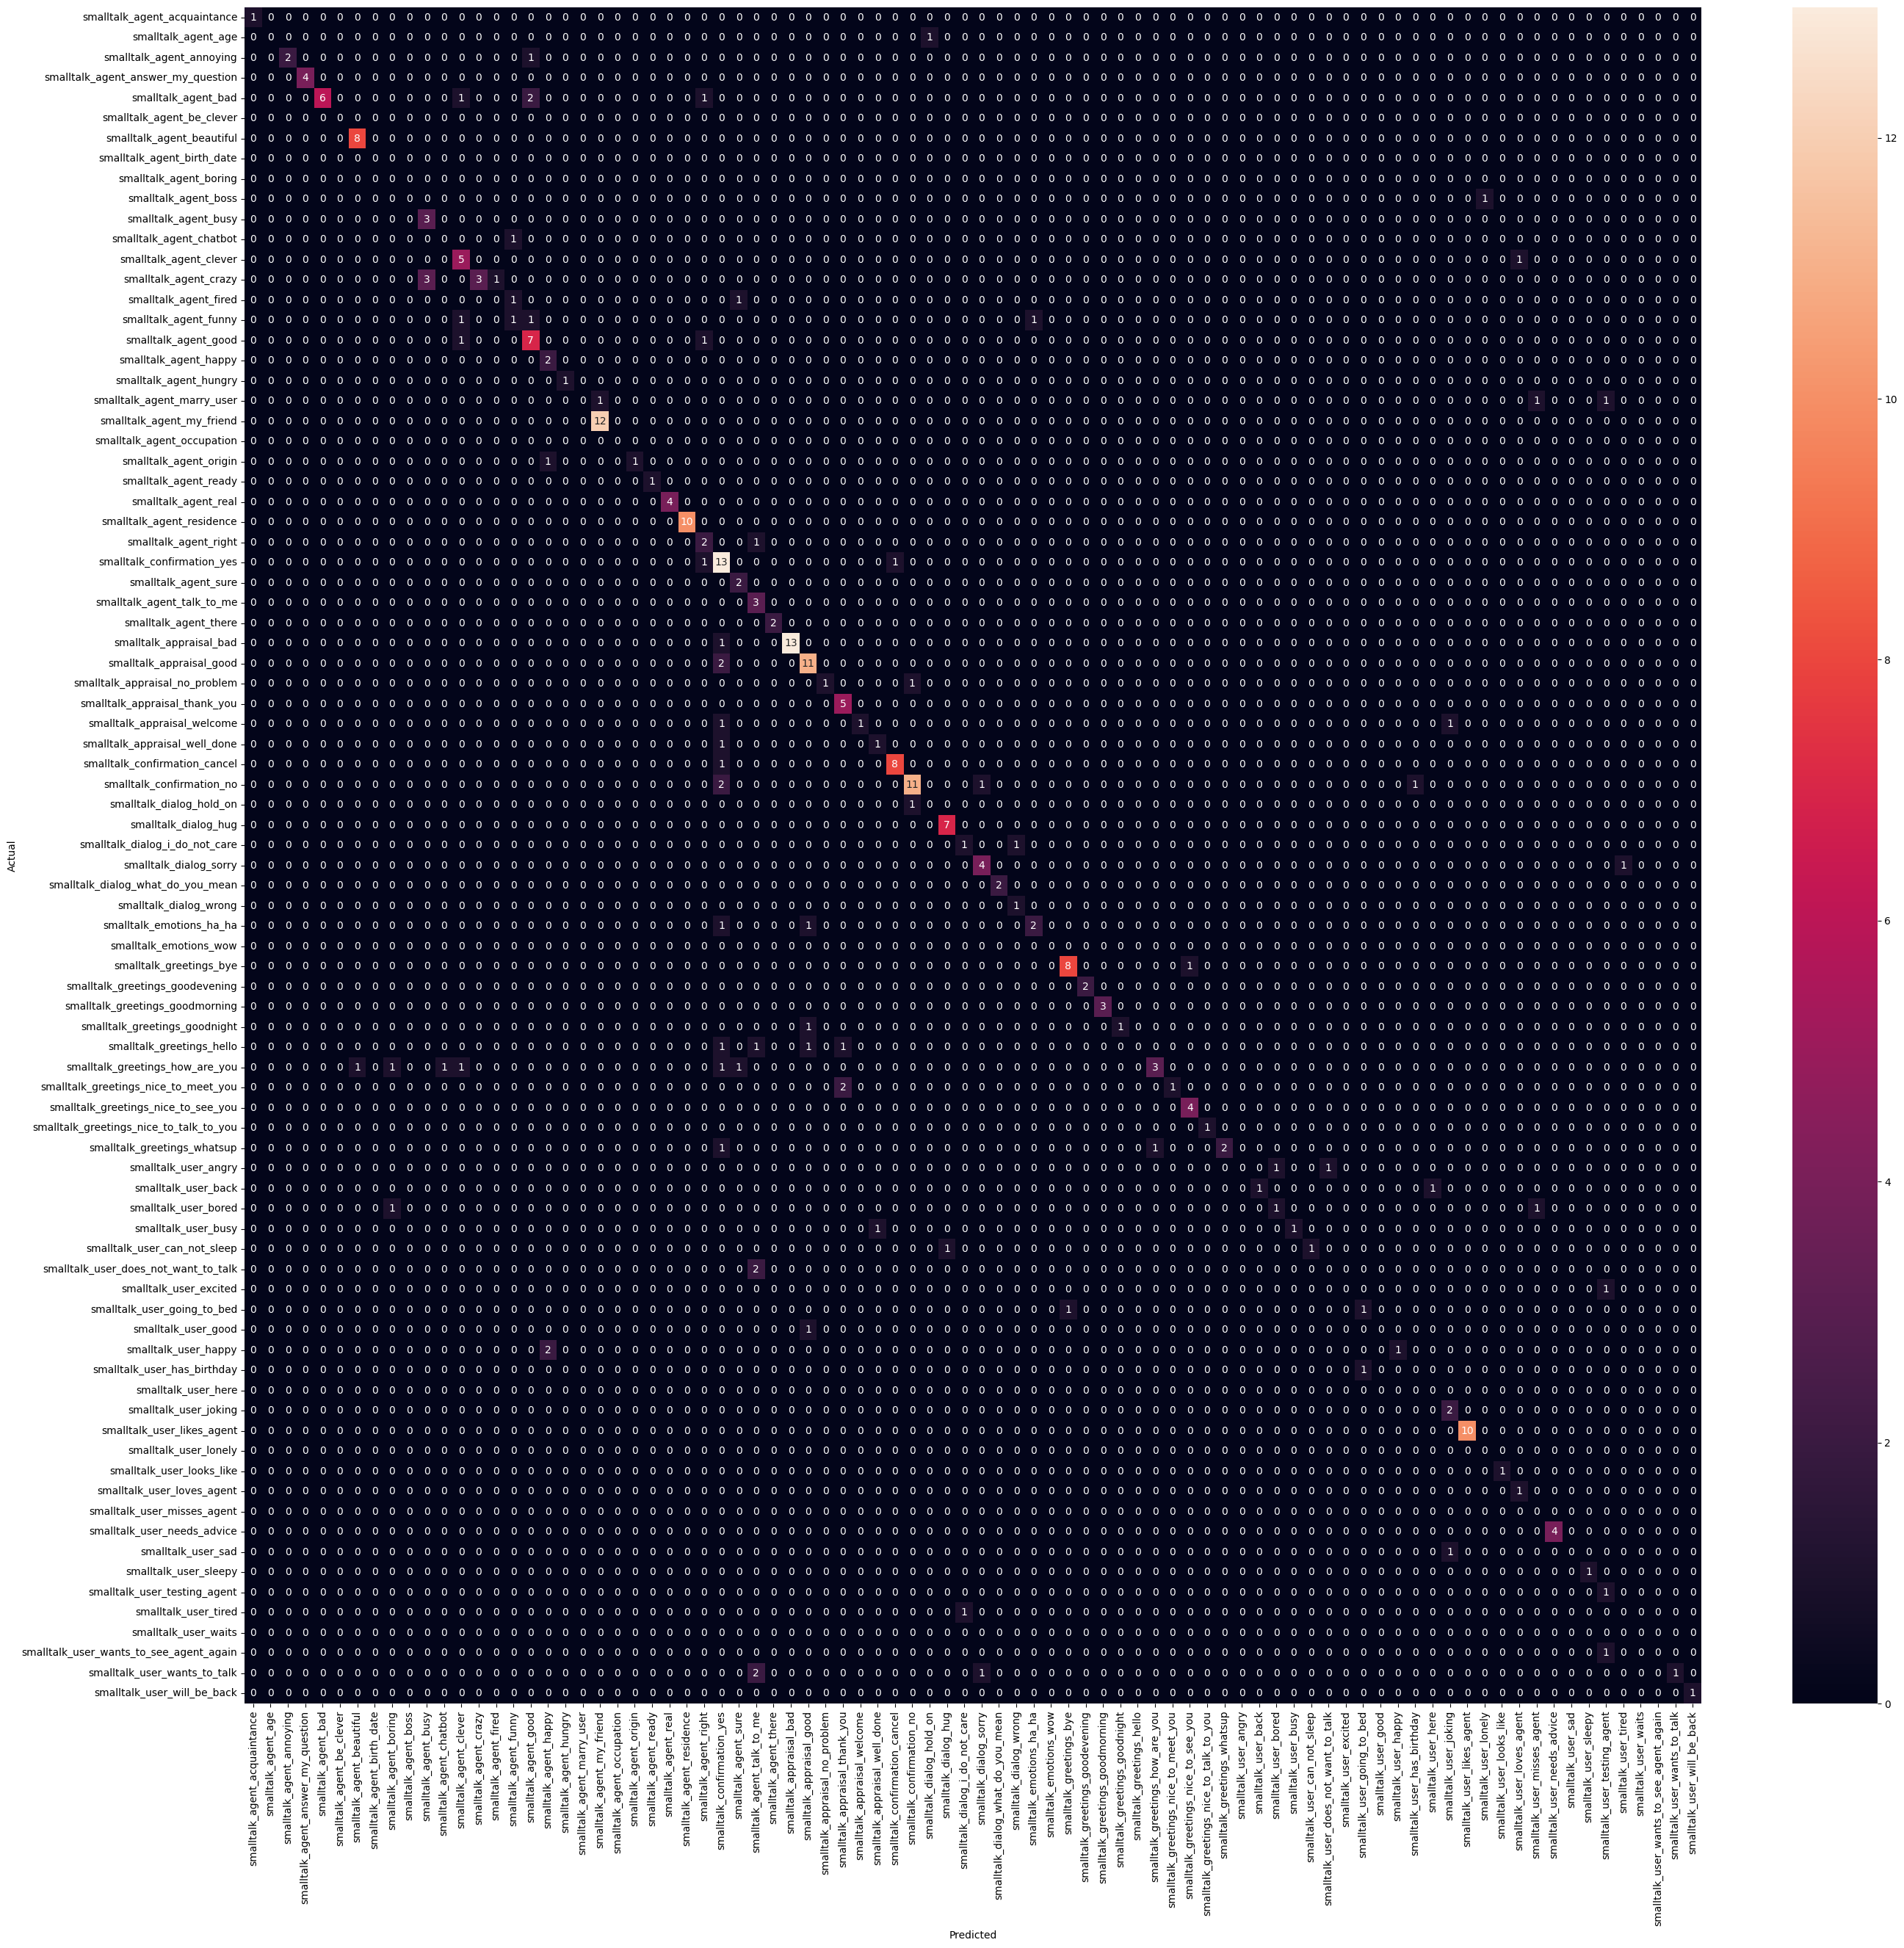

In [2]:

# ploting confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_mtx = tf.math.confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(32, 30))
sns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_test = y_test_classes
y_pred = y_pred_classes
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro',zero_division=1)
recall = recall_score(y_test, y_pred, average='macro',zero_division=1)
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))

Accuracy: 0.725
Precision: 0.73
Recall: 0.64
F1 Score: 0.57
